Original tutorial: https://www.tutorialspoint.com/gensim/gensim_creating_lda_topic_model.htm<br>
Secondary tutorial: https://radimrehurek.com/gensim/models/ldamodel.html

In [4]:
import warnings
warnings.filterwarnings('ignore') #There is deprication warnings using VSCode I would rather avoid

import re
import numpy as np 
import pandas as pd 
import gensim
import gensim.corpora as corpora
import os

from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt 

from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train')
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from','subject','re','edu','use'])

In [6]:
def clean_data(data):
    data = [re.sub('\S*@\Ss?', '', sent) for sent in data]
    data = [re.sub('\s+', ' ', sent) for sent in data]
    data = [re.sub("\'","",sent) for sent in data]
    return data

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = clean_data(newsgroups_train.data)
data_words = list(sent_to_words(data))

In [7]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [8]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
data_lemmatized = lemmatization(data_words_bigrams)

In [9]:
def build_or_load_lda_model(data,name,num_topics,folder='',passes=10):
    model_name = name + "_lda_t" + str(num_topics)
    if os.path.exists(folder + model_name):
        lda_model = gensim.models.LdaModel.load(folder + model_name)
        id2word = corpora.Dictionary.load(folder + model_name + '.id2word')
        corpus = [id2word.doc2bow(text) for text in data]
    else:
        id2word = corpora.Dictionary(data)
        corpus = [id2word.doc2bow(text) for text in data]

        lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus
            ,id2word=id2word
            ,num_topics=num_topics
            ,random_state=100
            ,update_every=1
            ,chunksize=100
            ,passes=passes
            ,alpha='auto'
            ,per_word_topics=True
        )
        lda_model.save(folder + model_name)

    return lda_model, id2word, corpus

lda_model, id2word, corpus = build_or_load_lda_model(data_lemmatized,'20newsgroups', 20)

In [10]:
#Print the topics
lda_model.print_topics(num_topics=5, num_words=5)

[(4,
  '0.067*"cable" + 0.049*"sgi" + 0.000*"trunk" + 0.000*"jon" + 0.000*"wiring"'),
 (7,
  '0.090*"m" + 0.040*"fi" + 0.039*"boy" + 0.025*"brave" + 0.022*"saturday"'),
 (11,
  '0.016*"evidence" + 0.011*"case" + 0.011*"group" + 0.010*"book" + 0.009*"issue"'),
 (8,
  '0.033*"say" + 0.027*"people" + 0.019*"god" + 0.019*"think" + 0.014*"believe"'),
 (14,
  '0.037*"line" + 0.036*"com" + 0.034*"organization" + 0.027*"write" + 0.022*"get"')]

In [11]:
# Print some model stats
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()

print('Perplexity: ', lda_model.log_perplexity(corpus), '\nCoherence Score: ', coherence_lda)

Perplexity:  -14.069856195252791 
Coherence Score:  nan


In [12]:
# Visualize the model
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, '20newsgroups_lda_model_vis.html')

In [13]:
# Query the model using previously unseen texts
other_texts = [
    ['computer','time','graph']
    ,['survey','response','eps']
    ,['human','system','computer']
]

other_corpus = [id2word.doc2bow(text) for text in other_texts]
vector = lda_model[other_corpus[0]]
print(vector)

([(2, 0.0650133), (3, 0.038348276), (6, 0.017036414), (8, 0.13890527), (9, 0.013866927), (10, 0.025442459), (11, 0.10610214), (13, 0.05552325), (14, 0.46662623), (17, 0.018005379)], [(99, [14, 2, 13]), (179, [14, 8, 11]), (23807, [])], [(99, [(2, 0.35902843), (13, 0.06872578), (14, 0.5721705)]), (179, [(8, 0.1282064), (11, 0.04465186), (14, 0.8271181)]), (23807, [])])


In [14]:
# update the model by incrementally training on the new corpus
lda_model.update(other_corpus)
vector = lda_model[other_corpus[0]]
print(vector)

([(2, 0.06872439), (3, 0.037760653), (6, 0.016843285), (8, 0.138793), (9, 0.013720686), (10, 0.025108228), (11, 0.10827782), (13, 0.05364513), (14, 0.46468195), (17, 0.017797235)], [(99, [14, 2, 13]), (179, [14, 8, 11]), (23807, [])], [(99, [(2, 0.38405102), (13, 0.0454304), (14, 0.5704779)]), (179, [(8, 0.11922685), (11, 0.042411383), (14, 0.8383411)]), (23807, [])])


### Determining the number of topics

In [15]:
def coherence_values_computation(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [16]:
start=1; limit=50; step=10

model_list, coherence_values = coherence_values_computation(
    corpus=corpus
    ,dictionary=id2word
    ,texts=data_lemmatized
    ,start=start, limit=limit, step=step
)

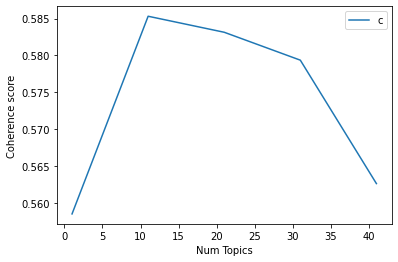

In [17]:
plt.plot(range(start,limit,step), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence values"), loc="best")
plt.show()

In [18]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_topics=5, num_words=5)

[(22,
  '0.018*"god" + 0.017*"say" + 0.013*"do" + 0.013*"think" + 0.012*"believe"'),
 (10,
  '0.038*"berkeley" + 0.023*"polygon" + 0.023*"do" + 0.011*"northeastern" + 0.009*"point"'),
 (4,
  '0.016*"israeli" + 0.015*"jew" + 0.012*"arab" + 0.012*"war" + 0.011*"israel"'),
 (27,
  '0.067*"bit" + 0.017*"block" + 0.012*"color" + 0.012*"fi" + 0.011*"fpu"'),
 (26,
  '0.016*"gun" + 0.010*"car" + 0.009*"state" + 0.008*"make" + 0.007*"get"')]

In [19]:
''' UNDER CONSTRUCTION - 10% found to be good
import random

rand_corpus = random.sample(corpus, int(len(corpus) / 10))
start=1; limit=50; step=10

model_list, coherence_values = coherence_values_computation(
    corpus=rand_corpus
    ,dictionary=id2word
    ,texts=data_lemmatized
    ,start=start, limit=limit, step=step
)
plt.plot(range(start,limit,step), coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence values"), loc="best")
plt.show()
'''

' UNDER CONSTRUCTION - 10% found to be good\nimport random\n\nrand_corpus = random.sample(corpus, int(len(corpus) / 10))\nstart=1; limit=50; step=10\n\nmodel_list, coherence_values = coherence_values_computation(\n    corpus=rand_corpus\n    ,dictionary=id2word\n    ,texts=data_lemmatized\n    ,start=start, limit=limit, step=step\n)\nplt.plot(range(start,limit,step), coherence_values)\nplt.xlabel("Num Topics")\nplt.ylabel("Coherence score")\nplt.legend(("coherence values"), loc="best")\nplt.show()\n'

In [20]:
def dominant_topics(ldamodel=lda_model, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()
    
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True
                )
            else:
                break

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

df_topic_sents_keywords = dominant_topics(ldamodel=optimal_model, corpus=corpus, texts=data)

In [21]:
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [22]:
df_dominant_topic.head(15)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,21.0,0.6618,"do, get, write, com, line, organization, artic...",From: am.umd.edu (wheres my thing) Subject: WH...
1,1,15.0,0.5798,"line, organization, drive, card, system, use, ...",From: arson.u.washington.edu (Guy Kuo) Subject...
2,2,21.0,0.5956,"do, get, write, com, line, organization, artic...",From: c.ecn.purdue.edu (Thomas E Willis) Subje...
3,3,21.0,0.2948,"do, get, write, com, line, organization, artic...",From: mber (Joe Green) Subject: Re: Weitek P90...
4,4,12.0,0.3177,"window, file, program, use, line, com, image, ...",From: ead-cfa.harvard.edu (Jonathan McDowell) ...
5,5,26.0,0.6093,"gun, car, state, make, get, do, go, president,...",From: ttoulu.tko.vtt.fi (Foxvog Douglas) Subje...
6,6,16.0,0.3698,"organization, line, mail, university, nntp_pos...",From: uads.uchicago.edu (brian manning delaney...
7,7,15.0,0.9137,"line, organization, drive, card, system, use, ...",From: ante.nmsu.edu (GRUBB) Subject: Re: IDE v...
8,8,12.0,0.8972,"window, file, program, use, line, com, image, ...",From: csvax.uni.edu Subject: WIn 3.0 ICON HELP...
9,9,21.0,0.4292,"do, get, write, com, line, organization, artic...",From: x1.cso.uiuc.edu (Stan Kerr) Subject: Re:...


In [23]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = [
   'Topic_Number', "Contribution_Perc", "Keywords", "Text"
]
sent_topics_sorteddf_mallet.head()

,Topic_Number,Contribution_Perc,Keywords,Text
0,0.0,0.9731,"com, write, line, organization, article, nntp_...",From: w.stratus.com (C. D. Tavares) Subject: R...
1,1.0,0.9899,"game, team, play, player, line, win, go, organ...",From: enon.Stanford.EDU (Nelson Lu) Subject: R...
2,2.0,0.9999,"ax, max, qax, vesa, mb, m, lg, pl_pl, kr, sl",Subject: roman.bmp 12/14 From: almon.usd.edu (...
3,3.0,0.9261,"people, group, law, post, write, article, orga...",From: nix.amherst.edu (Tim Pierce) Subject: Re...
4,4.0,0.9613,"israeli, jew, arab, war, israel, state, write,...",Organization: The American University - Univer...


In [24]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat(
   [topic_num_keywords, topic_counts, topic_contribution], axis=1
)
df_dominant_topics.columns = [
   'Dominant-Topic', 'Topic-Keywords', 'Num_Documents', 'Perc_Documents'
]
df_dominant_topics

,Dominant-Topic,Topic-Keywords,Num_Documents,Perc_Documents
0.0,21.0,"do, get, write, com, line, organization, artic...",745.0,0.0658
1.0,15.0,"line, organization, drive, card, system, use, ...",712.0,0.0629
2.0,21.0,"do, get, write, com, line, organization, artic...",10.0,0.0009
3.0,21.0,"do, get, write, com, line, organization, artic...",285.0,0.0252
4.0,12.0,"window, file, program, use, line, com, image, ...",298.0,0.0263
...,...,...,...,...
11309.0,28.0,"food, disease, medical, patient, doctor, cause...",NaN,NaN
11310.0,15.0,"line, organization, drive, card, system, use, ...",NaN,NaN
11311.0,15.0,"line, organization, drive, card, system, use, ...",NaN,NaN
11312.0,20.0,"year, run, well, hit, good, line, last, do, po...",NaN,NaN
